In [1]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from utils import *
from collections import namedtuple

import torch as tr
import gym

%load_ext autoreload
%autoreload 2

In [2]:
expert = tr.load('experts/agent_00-tasklen50-ne_3002-TD0')

In [3]:
def calc_traj_is(X):
  Y = -tr.ones([len(X)])
  for t in range(len(X),0,-1):
    Y[len(X)-t] = X[-t:].prod(0)
  return Y

def experiment(nseeds,neps,kw={},expert_flag=True,expert_trials=None):
  """
  interactrion logic
  a < agent(s,h)
  s',r  < env (a)
  
  """
  metric = np.zeros((nseeds,neps))
  data = np.zeros((4,nseeds,neps))
  # loop over seeds
  for s in range(nseeds):
    np.random.seed(s)
    tr.manual_seed(s)
    # setup
    learner = ACAgent(**kw)
    task = Task(task_name='CartPole-v1',max_ep_len=50)
    for e in range(neps):
      if expert_flag & (e>=expert_trials[0]) & (e<expert_trials[1]):
        actor = expert
      else:
        actor = learner
      # sample traj 
      traj = task.play_ep(pi=learner.act) #####
      expD = unpack_expL(traj)
      ## compute IS
      # behavior pi
      _vh,muact = actor.forward(expD['state'])
      mu_a_s = muact.softmax(-1)
      # learner pi
      _vh,piact = learner.forward(expD['state'])
      pi_a_s = piact.softmax(-1)
      ## IS WEIGHT
      is_weight = pi_a_s/mu_a_s
#       print(is_weight)
      is_weight = tr.max(tr.tensor(0),tr.min(tr.tensor(1),is_weight))
#       print(is_weight)
      is_weight = tr.gather(is_weight,1,tr.tensor(expD['action']).unsqueeze(1))
#       print(is_weight.shape,is_weight)
#       assert False
#       expD['is'] = is_weight.squeeze()
      ## update
      learner.update(expD)
      ## eval 
      traj_ev = task.play_ep(pi=learner.act)
      expD_ev = unpack_expL(traj_ev)
      epdata = learner.eval(expD_ev)
      # record
      metric[s,e] = np.sum(expD_ev['reward'])
      data[0,s,e] = epdata['entropy']
      data[1,s,e] = epdata['delta']
      data[2,s,e] = is_weight.mean()
      data[3,s,e] = is_weight.prod()
  return metric,data

In [4]:
ns,ne = 2,2000

print('x1')
expert_trials = (0,ne)
metricE1,dataE1 = experiment(ns,ne,kw={'TDupdate':False,'learnrate':0.001,'stsize':35},
                             expert_flag=True,
                             expert_trials=expert_trials
                            )

# print('x2')
# expert_trials = (1900,2100)
# metricE0,dataE0 = experiment(ns,ne,kw={'TDupdate':False,'learnrate':0.001,'stsize':35},
#                             expert_flag=True,
#                             expert_trials=expert_trials
#                             )



x1


In [5]:
metricE0,dataE0 = metricE1,dataE1

In [6]:
w = 10
movavg = lambda X: np.mean([X[i:i+w] for i in range(len(X)-w)],1)

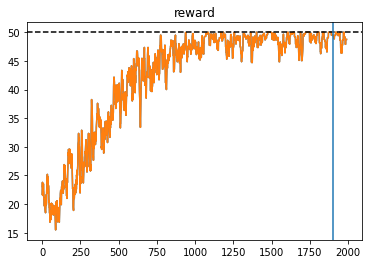

In [7]:
for metric in [metricE1,metricE0]:
  M = metric.mean(0)
  M = movavg(M)
  plt.plot(M)
plt.axhline(50,c='k',ls='--')
plt.title('reward')
plt.axvline(1900)

Text(0.5, 1.0, 'entropy of pi')

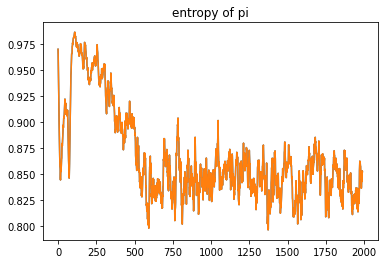

In [8]:
for data in [dataE1,dataE0]:
  M = data[0].mean(0)
  M = movavg(M)
  plt.plot(M)
plt.title('entropy of pi')

Text(0.5, 1.0, 'value estimate error')

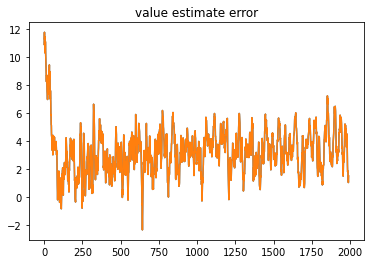

In [9]:
for data in [dataE1,dataE0]:
  M = data[1].mean(0)
  M = movavg(M)
  plt.plot(M)
plt.title('value estimate error')

Text(0.5, 1.0, 'mean IS weight')

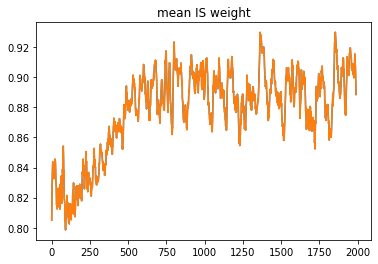

In [10]:
for data in [dataE1,dataE0]:
  M = data[2].mean(0)
  M = movavg(M)
  plt.plot(M)
plt.title('mean IS weight')
# plt.ylim(-0.05,1.05)

Text(0.5, 1.0, 'prod IS weight')

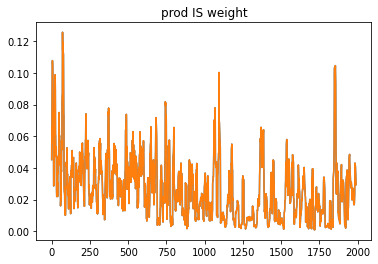

In [11]:
for data in [dataE1,dataE0]:
  M = data[3].mean(0)
  M = movavg(M)
  plt.plot(M)
plt.title('prod IS weight')
# plt.ylim(-0.05,1.05)